In [1]:
from cscg_actions import *
from ged import *
from util import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import random
import os
import pickle

In [2]:
def generate_custom_colors(num_unique_observations):
    # Define a fixed set of custom colors as RGB values
    predefined_colors = np.array([
        [214, 214, 214],
        [85, 35, 157],
        [253, 252, 144],
        [114, 245, 144],
        [151, 38, 20],
        [239, 142, 192],
        [214, 134, 48],
        [140, 194, 250],
        [72, 160, 162],
    ])

    # If the number of unique observations is greater than the number of predefined colors,
    # cycle through the predefined colors to ensure enough colors are available
    if num_unique_observations > len(predefined_colors):
        extra_colors_needed = num_unique_observations - len(predefined_colors)
        additional_colors = np.tile(predefined_colors, (extra_colors_needed // len(predefined_colors) + 1, 1))
        custom_colors = np.vstack((predefined_colors, additional_colors))[:num_unique_observations]
    else:
        custom_colors = predefined_colors[:num_unique_observations]

    return custom_colors


# Function to create a lattice graph with variable nodes, observations, and aliased states
def create_modular_graph_varied(num_nodes=15, num_observations=10000, num_aliased_states=10, num_modules=3):
    if num_nodes < 4:
        raise ValueError("num_nodes must be at least 4 to allow for meaningful connectivity.")

    if num_nodes < num_modules:
        raise ValueError("Number of nodes must be at least equal to the number of modules to form a meaningful structure.")

    # Initialize the adjacency matrix
    T = np.zeros((num_nodes, num_nodes))

    # Calculate the size of each module
    module_size = num_nodes // num_modules

    for module_index in range(num_modules):
        module_start = module_index * module_size
        # For the last module, extend to the end of the node list
        module_end = module_start + module_size if module_index < num_modules - 1 else num_nodes

        # Fully connect nodes within the module
        for i in range(module_start, module_end):
            for j in range(module_start, module_end):
                if i != j:
                    T[i, j] = 1.0
    # Optionally, add sparse inter-module connections
    # Example: Connecting last node of one module to first node of the next module
    for module_index in range(num_modules - 1):
        module_end = (module_index + 1) * module_size - 1
        next_module_start = (module_end + 1) % num_nodes
        T[module_end, next_module_start] = 1.0
        T[next_module_start, module_end] = 1.0
    # connect first and last module
    T[0, num_nodes-1] = 1.0
    T[num_nodes-1,0] = 1.0



    # Generate observations based on random walks on the lattice graph
    states = [np.random.choice(range(num_nodes))]  # Start from a random state
    for _ in range(1, num_observations):
        current_state = states[-1]
        possible_next_states = np.where(T[current_state, :] > 0)[0]
        next_state = np.random.choice(possible_next_states)
        states.append(next_state)


    # Map states to observations with aliasing
    if num_aliased_states > num_nodes or num_aliased_states < 1:
        raise ValueError("num_aliased_states must be between 1 and the number of nodes.")


    unique_obs = np.arange(num_nodes - num_aliased_states)
    for n in range(num_aliased_states):
      unique_obs = np.append(unique_obs,random.choice(unique_obs))
    state_to_obs = unique_obs # Aliasing version

    # Create observation data
    x = state_to_obs[states]

    # plt.matshow(T)
    # plt.show()

    return x, T, state_to_obs

# Function to create a lattice graph with variable nodes, observations, and aliased states
def create_lattice_graph_varied(num_nodes=15, num_observations=10000, num_aliased_states=10):
    if num_nodes < 4:
        raise ValueError("num_nodes must be at least 4 to allow for meaningful connectivity.")

    # Initialize the adjacency matrix
    T = np.zeros((num_nodes, num_nodes))

    # Connect each node to its immediate and second-order neighbors with wrapping
    for i in range(num_nodes):
        for offset in [-2, -1, 1, 2]:  # Immediate and second-order neighbors
            j = (i + offset) % num_nodes
            T[i, j] = 1.0

    # Generate observations based on random walks on the lattice graph
    states = [np.random.choice(range(num_nodes))]  # Start from a random state
    for _ in range(1, num_observations):
        current_state = states[-1]
        possible_next_states = np.where(T[current_state, :] > 0)[0]
        next_state = np.random.choice(possible_next_states)
        states.append(next_state)


    # Map states to observations with aliasing
    if num_aliased_states > num_nodes or num_aliased_states < 1:
        raise ValueError("num_aliased_states must be between 1 and the number of nodes.")


    unique_obs = np.arange(num_nodes - num_aliased_states)
    for n in range(num_aliased_states):
      unique_obs = np.append(unique_obs,random.choice(unique_obs))
    state_to_obs = unique_obs # Aliasing version

    # Create observation data
    x = state_to_obs[states]

    # plt.matshow(T)

    return x, T, state_to_obs


In [3]:
# Create observation data

num_nodes = 30
num_observations = 50000
num_aliased_states = 2  # Adjust this to change the number of aliased states
num_clones = 10
num_modules=3
var_clones = np.arange(1,15,1)
# total_modularity_scores = []
var_aliasing = np.arange(2,4,1)

aliasing = 3

num_aliased_states = num_nodes//aliasing  # Adjust this to change the number of aliased states


x = create_lattice_graph_varied(num_nodes, num_observations, num_aliased_states)
a = np.zeros(len(x), dtype=int)

In [4]:
# nclone=1
# a,x,rc = datagen_structured_obs_room(room, length=50000)
alpha_results_nclones = []
alpha_results_totalclone = []
alphas = np.arange(0.1, 1, 0.1)
seeds = np.arange(0,100,1)
currmodel = 'lattice'
n_orig_clones = 70

#   # Create observation data
#   x = create_modular_graph_varied(num_nodes, num_observations, num_aliased_states, num_modules)
#   a = np.zeros(len(x), dtype=int)

#   n_clones = np.ones(max(x)+1, dtype=np.int64) * num_clones
#   container = TableContainer()
total_modularity_scores = []
for alpha in alphas: 
    seed_results_totalclone = []
    seed_results_nclones = []
    modularity_scores = []
    for seed in seeds: 
        filename = 'model_' + currmodel + '_alpha_' + str(alpha) + '_seed_' + str(seed) + '.pkl'
        folderpath = 'models'
        fullpath = os.path.join(folderpath, filename)
        if os.path.isfile(fullpath):
            try: 
                print(filename)
                with open(fullpath, 'rb') as file: 
                    chmm = pickle.load(file)
            except (pickle.UnpicklingError, EOFError) as e: 
                print("failed")
                
        chmm.pseudocount = 2e-10
        chmm.T += chmm.pseudocount
        states = chmm.decode(x, a)[1]
        n_states = len(np.unique(states))

        custom_colors = generate_custom_colors(max(x)+1)/256
        arr = np.arange(max(x)+1)
        np.random.shuffle(arr)
        cmap = colors.ListedColormap(custom_colors[arr])

        temp_output_file = f"lattice_graph_num_nodes_{num_nodes}.png"  # Temporary file for each clone
        graph, modularity_score, v, g = plot_graph_modularity(chmm, x, a, output_file=temp_output_file, cmap=cmap)
        # graph, v, g = plot_graph(chmm, x, a, output_file=temp_output_file, cmap=cmap)
        # print('Ground truth number of nodes: {}, number of nodes recovered {}'.format(num_nodes, len(v)))
        # Display the image inline
        # display(Image(filename=temp_output_file))
        
        
        modularity_scores.append(modularity_score)

        n_clones = 0
        container = chmm.container
        table = []
        for roomid in range(len(container.groups_of_tables)):
            print("Room {} has {} tables (clones)".format(roomid, len(container.groups_of_tables[roomid])))
            n_clones+=len(container.groups_of_tables[roomid])
            table.append(len(container.groups_of_tables[roomid]))
        print("Total clones used: {}".format(n_clones))
        print("Clones that would have been used by the original code: {}".format(len(container.groups_of_tables) * 5))       
        
        seed_results_totalclone.append(n_clones)
        seed_results_nclones.append(table)
    alpha_results_totalclone.append(seed_results_totalclone)
    alpha_results_nclones.append(seed_results_nclones)
    total_modularity_scores.append(modularity_scores)
            
        

model_lattice_alpha_0.1_seed_0.pkl


TypeError: only integer scalar arrays can be converted to a scalar index

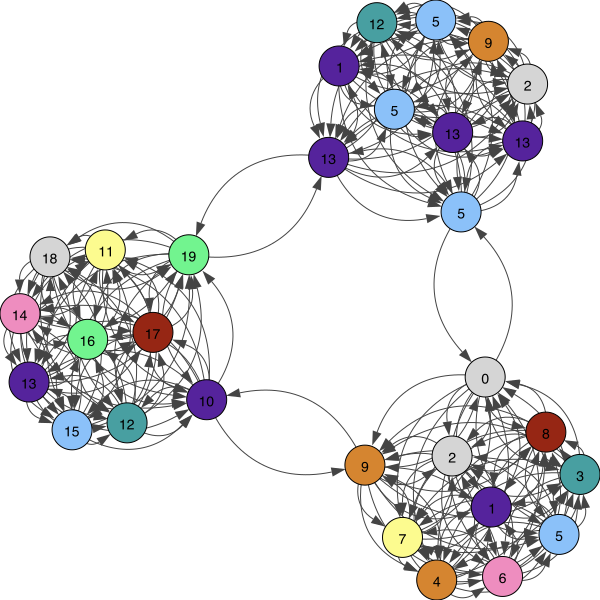

In [37]:
import igraph as ig

# def plot_graph(T):
#     # Convert adjacency matrix to an edge list
#     g = ig.Graph.Adjacency((T > 0).tolist())
#     g.es['weight'] = T[T.nonzero()]  # Set weights

#     # Plot the graph
#     output_file = 'aa.png'
#     out = igraph.plot(
#     g,
#     output_file,
#     layout=g.layout("kamada_kawai"),
#     vertex_color=colors,
#     # vertex_label=v,
#     vertex_size=30,
#     margin=50,
# )

    # layout = g.layout('kk')  # Kamada-Kawai layout for nice graph drawing
    # ig.plot(g, layout=layout, vertex_label=range(g.vcount()), margin=20)
    # # ig.show()
    # display(Image(filename='a.jpg'))

xm, Tm, sm = create_modular_graph_varied(num_nodes, num_observations, num_aliased_states)
xl,Tl, sl = create_lattice_graph_varied(num_nodes, num_observations, num_aliased_states)


node_labels = sm
# if multiple_episodes:
    # node_labels -= 1
colors = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]
# out=[]

g = g = ig.Graph.Adjacency((Tm > 0).tolist())
g.es['weight'] = Tm[Tm.nonzero()]  # Set weights
ig.plot(g, 'modular.png', vertex_color=colors, vertex_label=node_labels, vertex_size=40)
# plot_graph(Tm)
# display(Image(filename=temp_output_file))

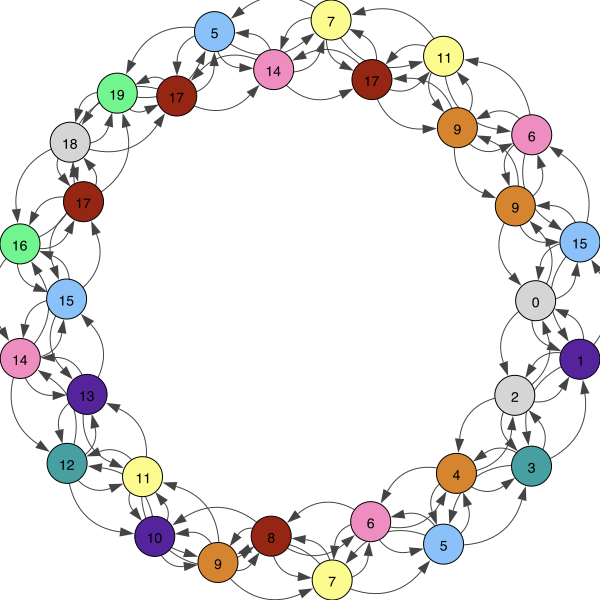

In [36]:
node_labels = sl
# if multiple_episodes:
    # node_labels -= 1
colors = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]
# out=[]

g = g = ig.Graph.Adjacency((Tl > 0).tolist())
g.es['weight'] = Tl[Tl.nonzero()]  # Set weights
ig.plot(g,'lattice.png', vertex_color=colors, vertex_label=node_labels, vertex_size=40, )

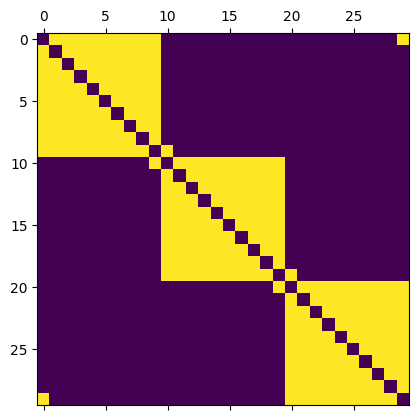

In [30]:
plt.matshow(Tm)

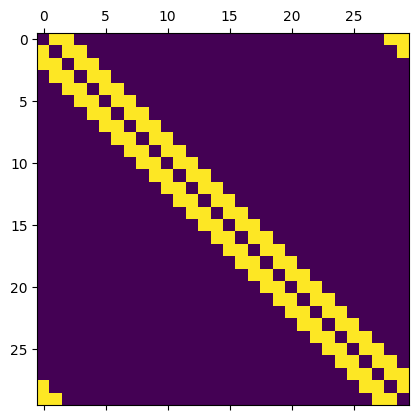

In [31]:
plt.matshow(Tl)

In [26]:
sm

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19,  4,  4, 17, 15,  0, 17, 17, 17,  4, 11])

In [7]:
n_clones = 0
container = TableContainer()
# n_clones = np.ones(n_emissions, dtype=np.int64) * nclone
# container = TableContainer()
chmm = CHMM_LCM(n_clones=n_clones, pseudocount=2e-3, x=x, a=a, container=container,alpha=alpha,seed=42)  # Initialize the model
progression = chmm.learn_em_T(x, a, n_iter=20,
                            # term_early=False,
                            )  # Training   use n_iter=1000 for better training

100%|██████████| 20/20 [01:00<00:00,  3.01s/it, New best model at epoch 19 saved with loss 3.2844]


In [9]:
np.shape(chmm.T)

(1, 37, 37)

In [10]:
states = chmm.decode(x, a)[1]

## Comparing the graph edit distance with the ground-truth graph

In [4]:
# import numpy as np
import igraph as ig


def grid_to_directed_igraph(grid):
    """
    Convert a 2D numpy array to a directed igraph.Graph.
    Each cell has bidirectional connections to its horizontal and vertical neighbors.
    """
    rows, cols = grid.shape
    adjacency_matrix = np.zeros((rows * cols, rows * cols), dtype=int)

    index = lambda r, c: r * cols + c

    for r in range(rows):
        for c in range(cols):
            current_index = index(r, c)

            # North
            if r > 0:
                north_index = index(r - 1, c)
                adjacency_matrix[current_index, north_index] = 1
                adjacency_matrix[north_index, current_index] = 1

            # South
            if r < rows - 1:
                south_index = index(r + 1, c)
                adjacency_matrix[current_index, south_index] = 1
                adjacency_matrix[south_index, current_index] = 1

            # East
            if c < cols - 1:
                east_index = index(r, c + 1)
                adjacency_matrix[current_index, east_index] = 1
                adjacency_matrix[east_index, current_index] = 1

            # West
            if c > 0:
                west_index = index(r, c - 1)
                adjacency_matrix[current_index, west_index] = 1
                adjacency_matrix[west_index, current_index] = 1

    # Creating an igraph from the adjacency matrix
    graph = ig.Graph.Adjacency((adjacency_matrix > 0).tolist(), mode=ig.ADJ_DIRECTED)
    return graph

# Example room array
room = np.array([
    [1, 2, 3, 0, 3, 1, 1, 1],
    [1, 1, 3, 2, 3, 2, 3, 1],
    [1, 1, 2, 0, 1, 2, 1, 0],
    [0, 2, 1, 1, 3, 0, 0, 2],
    [3, 3, 1, 0, 1, 0, 3, 0],
    [2, 1, 2, 3, 3, 3, 2, 0],
])

directed_igraph = grid_to_directed_igraph(room)
print("Directed Graph Representation with igraph:")
print(directed_igraph)

Directed Graph Representation with igraph:
IGRAPH D--- 48 164 --
+ edges:
 0 ->  1  8         12 ->  4 11 13 20   24 -> 16 25 32      36 -> 28 35 37 44
 1 ->  0  2  9      13 ->  5 12 14 21   25 -> 17 24 26 33   37 -> 29 36 38 45
 2 ->  1  3 10      14 ->  6 13 15 22   26 -> 18 25 27 34   38 -> 30 37 39 46
 3 ->  2  4 11      15 ->  7 14 23      27 -> 19 26 28 35   39 -> 31 38 47
 4 ->  3  5 12      16 ->  8 17 24      28 -> 20 27 29 36   40 -> 32 41
 5 ->  4  6 13      17 ->  9 16 18 25   29 -> 21 28 30 37   41 -> 33 40 42
 6 ->  5  7 14      18 -> 10 17 19 26   30 -> 22 29 31 38   42 -> 34 41 43
 7 ->  6 15         19 -> 11 18 20 27   31 -> 23 30 39      43 -> 35 42 44
 8 ->  0  9 16      20 -> 12 19 21 28   32 -> 24 33 40      44 -> 36 43 45
 9 ->  1  8 10 17   21 -> 13 20 22 29   33 -> 25 32 34 41   45 -> 37 44 46
10 ->  2  9 11 18   22 -> 14 21 23 30   34 -> 26 33 35 42   46 -> 38 45 47
11 ->  3 10 12 19   23 -> 15 22 31      35 -> 27 34 36 43   47 -> 39 46


In [31]:
import igraph as ig
from queue import PriorityQueue

def heuristic(graph1, graph2):
    """
    Heuristic that considers both vertices and edges.
    """
    v_diff = abs(len(graph1.vs) - len(graph2.vs))
    e_diff = abs(len(graph1.es) - len(graph2.es))
    return v_diff + e_diff

def graph_edit_distance_igraph(graph1, graph2, max_iterations=10000):
    """
    Computes the approximate graph edit distance between two graphs
    using the A* algorithm with practical limitations.
    """
    frontier = PriorityQueue()
    graph_id = 0
    graphs = {graph_id: graph1}
    frontier.put((heuristic(graph1, graph2), 0, graph_id))
    graph_id += 1

    iterations = 0
    while not frontier.empty() and iterations < max_iterations:
        iterations += 1
        estimated_cost, actual_cost, current_graph_id = frontier.get()
        current_graph = graphs[current_graph_id]

        # Check if we reached the target structure
        if heuristic(current_graph, graph2) == 0:
            return actual_cost

        # Try adding and removing vertices and edges
        if len(current_graph.vs) < 20:  # Limit vertex count for demo purposes
            new_graph = current_graph.copy()
            new_graph.add_vertices(1)
            new_cost = actual_cost + 1
            graphs[graph_id] = new_graph
            frontier.put((new_cost + heuristic(new_graph, graph2), new_cost, graph_id))
            graph_id += 1

        if len(current_graph.vs) > 1:
            for v in range(len(current_graph.vs)):
                new_graph = current_graph.copy()
                new_graph.delete_vertices(v)
                new_cost = actual_cost + 1
                graphs[graph_id] = new_graph
                frontier.put((new_cost + heuristic(new_graph, graph2), new_cost, graph_id))
                graph_id += 1
                break  # Limit to one vertex modification per expansion for demo

        # Check if edges can be modified if graphs are similar in vertices but differ in edges
        if len(current_graph.vs) == len(graph2.vs):
            for e in current_graph.es:
                new_graph = current_graph.copy()
                new_graph.delete_edges(e.index)
                new_cost = actual_cost + 1
                graphs[graph_id] = new_graph
                frontier.put((new_cost + heuristic(new_graph, graph2), new_cost, graph_id))
                graph_id += 1
                break  # Limit to one edge modification for demo

    return float('inf')  # Return infinity if no solution found within the constraints

# Example usage would involve defining specific igraph instances to test this function.

# # Example usage with igraph.Graph
# room_graph = ig.Graph.Adjacency((room > 0).tolist())
# target_graph = ig.Graph.Adjacency((np.random.randint(0, 2, room.shape) > 0).tolist())

# ged = graph_edit_distance_igraph(room_graph, target_graph)
# print(f"Graph Edit Distance: {ged}")


In [38]:
def spectral_similarity(graph1, graph2):
    L1 = np.array(graph1.laplacian())
    L2 = np.array(graph2.laplacian())
    eigenvalues1 = np.sort(np.linalg.eigvals(L1))
    eigenvalues2 = np.sort(np.linalg.eigvals(L2))

    # Pad the smaller array of eigenvalues to match the larger one
    max_len = max(len(eigenvalues1), len(eigenvalues2))
    eigenvalues1 = np.pad(eigenvalues1, (0, max_len - len(eigenvalues1)), 'constant')
    eigenvalues2 = np.pad(eigenvalues2, (0, max_len - len(eigenvalues2)), 'constant')

    # Calculate the Euclidean distance between the eigenvalue arrays
    distance = np.linalg.norm(eigenvalues1 - eigenvalues2)
    return distance

In [22]:
np.arange(0,100,10)

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

In [40]:
nclone=1
a,x,rc = datagen_structured_obs_room(room, length=50000)
# alpha_results_nclones = []
# alpha_results_totalclone = []
geds = []
alphas = np.arange(0.1, 1, 0.1)
seeds = np.arange(0,100,10) # modified to save time
currmodel = 'spatial'
n_orig_clones = 70
for alpha in alphas: 
    # seed_results_totalclone = []
    # seed_results_nclones = []
    seed_geds = []
    for seed in seeds: 
        filename = 'model_' + currmodel + '_alpha_' + str(alpha) + '_seed_' + str(seed) + '.pkl'
        folderpath = 'models'
        fullpath = os.path.join(folderpath, filename)
        if os.path.isfile(fullpath):
            try: 
                print(filename)
                with open(fullpath, 'rb') as file: 
                    chmm = pickle.load(file)
            except (pickle.UnpicklingError, EOFError) as e: 
                print("failed")
        chmm.pseudocount = 0.01

        temp_output_file = f"rectangular_room_graph_large_num_clones_{nclone}.png" # Temporary file for each clone
        # graph, v, g = plot_graph(chmm, x, a, output_file=temp_output_file, cmap=cmap)

        graph, v, g = plot_graph(chmm, x, a, output_file=temp_output_file, cmap=cmap)
        # score = graph_edit_distance_igraph(g, directed_igraph)
        score = spectral_similarity(g,directed_igraph)
        seed_geds.append(score)
        print(score)
    geds.append(seed_geds)

model_spatial_alpha_0.1_seed_0.pkl
decode C: (4, 14, 14)
decode T: (4, 14, 14)
decode Pi: (4,)
decode n_clones: [6 4 3 1]
37.22372935708246
model_spatial_alpha_0.1_seed_10.pkl
decode C: (4, 9, 9)
decode T: (4, 9, 9)
decode Pi: (4,)
decode n_clones: [2 2 3 2]
31.55474045508928
model_spatial_alpha_0.1_seed_20.pkl
decode C: (4, 13, 13)
decode T: (4, 13, 13)
decode Pi: (4,)
decode n_clones: [2 4 3 4]
34.52754543037845
model_spatial_alpha_0.1_seed_30.pkl
decode C: (4, 10, 10)
decode T: (4, 10, 10)
decode Pi: (4,)
decode n_clones: [2 2 3 3]
34.490746699336164
model_spatial_alpha_0.1_seed_40.pkl
decode C: (4, 10, 10)
decode T: (4, 10, 10)
decode Pi: (4,)
decode n_clones: [1 2 5 2]
32.68821391306014
model_spatial_alpha_0.1_seed_50.pkl
decode C: (4, 8, 8)
decode T: (4, 8, 8)
decode Pi: (4,)
decode n_clones: [2 2 2 2]
31.007904956770762
model_spatial_alpha_0.1_seed_60.pkl
decode C: (4, 11, 11)
decode T: (4, 11, 11)
decode Pi: (4,)
decode n_clones: [2 6 2 1]
31.464731301515975
model_spatial_alpha

In [41]:
np.mean(geds,axis=0)


array([38.87402363, 40.89811239, 40.33908948, 40.65842353, 40.71010805,
       40.80950581, 41.81042349, 43.12211455, 40.92801616, 41.43108122])

In [42]:
np.std(geds,axis=0)

array([5.14637577, 3.68115964, 3.77352664, 3.77758989, 4.5162894 ,
       4.74330065, 4.19387617, 6.56863571, 2.67718338, 4.25676414])

In [39]:
spectral_similarity(g, directed_igraph)

34.490746699336164